# K近邻分类算法
## 公式笔记

* Lp距离公式
$$ 
L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{l=1}^{n}\left|x_{i}^{(l)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}
$$

* $ p=2 $ 为欧氏距离
$$ 
L_{2}\left(x_{i}, x_{j}\right)=\left(\sum_{l=1}^{n}\left|x_{i}^{(l)}-x_{j}^{(l)}\right|^{2}\right)^{\frac{1}{2}}
 $$

* $ p=1 $ 为曼哈顿距离
$$ 
L_{1}\left(x_{i}, x_{j}\right)=\sum_{l=1}^{n}\left|x_{i}^{(l)}-x_{j}^{(l)}\right|
 $$

## KNNClassifier实现


In [7]:
#优先队列


In [8]:
class kdTreeNode:
    def __init__(self, x, index, target_dim, parent):
        '''
        所有节点共用x
        利用索引来表示该节点所覆盖的数据
        '''
        self.x = x
        self.index = index
        self.target_dim = target_dim
        self.parent = parent
        self.left = None
        self.right = None
        self.target_index = None
    def set_left(self, left):
        self.left = left
    def set_right(self, right):
        self.right = right
    def set_target_index(self, target_index):
        self.target_index = target_index
class kdTree:
    def __init__(self, x):
        self.dim = len(x[0])
        self.x = x.copy()
        self.tree_done = False
    def _fit(self, node):
        if(node == None):
            return
        left_index, mid_index, right_index = self._get_sorted_index(node.index, node.target_dim)
        node.set_target_index(mid_index)
        #print(node.x[mid_index])
        if(len(left_index) != 0):
            #print('left')
            node.set_left(kdTreeNode(self.x, left_index, (node.target_dim + 1)%self.dim, node))
            self._fit(node.left)
        if(len(right_index) != 0):
            #print('right')
            node.set_right(kdTreeNode(self.x, right_index, (node.target_dim + 1)%self.dim, node))
            self._fit(node.right)
    def fit(self):
        self.root = kdTreeNode(self.x, np.arange(len(self.x)), 0, None)
        self._fit(self.root)
        return self
    def _get_sorted_index(self, index_list, dim):
        temp_val = np.hstack((self.x[index_list], np.array([index_list]).T))
        mid = len(temp_val) // 2
        temp_val = temp_val[temp_val[:,dim].argsort()]
        return temp_val[:mid][:, -1], temp_val[mid][-1], temp_val[mid+1:][:, -1]
    def _fix_max_k():
        pass
    def search_k_neighbour(self, x, k):
        k_neighbour = np.zeros()
        
    def _search_k_neighbour(self, node)
        target_val = node.x[node.target_index]
        if((target_val == x).all()):
            pass
        elif(x[node.target_dim] < target_val[node.target_dim]):
            if(node.left != None):
                self._search_k_neighbour(node.left)
        else:
            if(node.right != None):
                self._search_k_neighbour(node.right)
                
        print(node.x[node.target_index])
                
                
            
        

SyntaxError: invalid syntax (<ipython-input-8-103bf24a4bd3>, line 53)

In [ ]:
import numpy as np
from math import *

class KNNClassifier:
    def __init__(self, dist_type):
        if(dist_type == 'm'):
            #曼哈顿距离
            self.dist_p = 1
        else:
            #e：欧氏距离
            self.dist_p = 2
    def _get_dist(self, x1, x2):
        #需要x维度相同
        dis = 0
        for i in zip(x1, x2):
            dis += pow(abs(x1 - x2), self.dist_p)
        dis = pow(dis, 1.0/self.dist_p)
        return dis
    def fit(self, x, y):
        '''
        只支持numpy二维数组
        '''
        self.tree = kdTree(x).fit()
        return self
        #self._get_dist(x[0], x[1])
    def searchKNeighbour(self, x, k):
         self.tree.searchKNeighbour(x, k)
            
#if __name__ == '__main__':
x = np.random.randint(1, 100, (10000, 3))
y = np.random.randint(1, 100, (10000, 1))
knn_clf = KNNClassifier(dist_type = 'e').fit(x, y)
knn_clf.searchKNeighbour([44, 16, 46], 3)

[ 7 14]
[7, 7] [0, 20]
[6 1]
[0, 7] [1, 1]
[6 1]
[6, 6] [0, 1]
[ 5 11]
[5, 5] [1, 7]
[14 12]
[7, 20] [12, 12]
[11 12]
[11, 11] [7, 12]


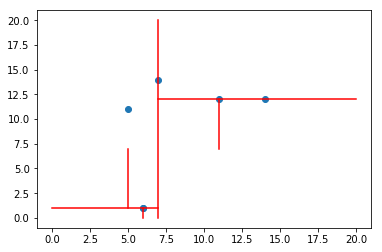

In [9]:
'''
验证kd树
'''
xx = np.random.randint(1, 20, (6, 2))
tree = kdTree(xx).fit()
node = tree.root
import matplotlib.pyplot as plt
def walk(node, low_edge, high_edge):
    if(node != None):
        print(node.x[node.target_index])
        if(node.target_dim == 0):
            print([node.x[node.target_index][node.target_dim], node.x[node.target_index][node.target_dim]], [low_edge, high_edge])
            plt.plot([node.x[node.target_index][node.target_dim], node.x[node.target_index][node.target_dim]], [low_edge, high_edge], color = 'red')
        else:
            print([low_edge, high_edge], [node.x[node.target_index][node.target_dim], node.x[node.target_index][node.target_dim]])
            plt.plot([low_edge, high_edge], [node.x[node.target_index][node.target_dim], node.x[node.target_index][node.target_dim]], color = 'red')
        walk(node.left, low_edge, node.x[node.target_index][node.target_dim])
        walk(node.right, node.x[node.target_index][node.target_dim], high_edge)
        
walk(node,0, 20)


plt.scatter(xx[:, 0], xx[:, 1])
plt.show()